# Book Recommender

There are two main approaches to create recommendations — personalized and non-personalized. The first one uses the information about each user to find the most relevant information to him. In contrast, non-personalized recommendations provide the user with general recommendations without any context of what the user wants or what his preferences are. Here, we discuss only personalized recommenders.

Every user has some preferences in relation to items offered by the service. It is possible to infer these preferences based on a variety of attributes (examples with books): book page view time, book clicks, adding to favorites, rating, writing reviews, and so on. All interactions between users and items can be converted into numbers and stored in a so-called user-item interactions matrix. Here is an example from [this article](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada):

![Interaction matrix](pics/interaction_matrix.png)

In general, the purpose of recommendation systems is to predict a rating that a user would give to an item that he has not rated yet. In a simple way, the personalized recommender algorithms can be classified as follows (the picture from the same [article](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada)):

![Classification of recommenders](pics/classification_of_recommenders.png)

Here, we will build several recommenders to get some understanding of how they work, what advantages and disadvantages they have.

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import Image
from dotenv import load_dotenv
from pandas.api.types import CategoricalDtype
from scipy.sparse import SparseEfficiencyWarning
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

from models.gradient_descent import RecommenderGD, RecommenderGDBiased
from models.memory_based import RecommenderII, RecommenderUU
from models.svd import RecommenderSVD

# Load environment variables
load_dotenv()

# Set random seeds and suppress warnings
RANDOM_SEED = int(os.environ['RANDOM_SEED'])
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SparseEfficiencyWarning)

# Data Preparation

To increase the size of training dataset, we combine information from [Book-Crossing](book_crossing/preprocessing.ipynb) and [Goodreads](goodreads/preprocessing.ipynb) datasets. However, their analysis showed that these datasets contain much unreliable and missing information. Thus, we will use only their ratings, and the book/author descriptions will be downloaded from [Penguin Random House](https://www.penguinrandomhouse.com/).
 
The analysis of PRH data is presented [here](penguin_random_house/preprocessing.ipynb), and the preprocessed data were saved [here](penguin_random_house/data_prep).

In [2]:
# Loading PRH data
path = os.path.join('penguin_random_house/data_prep')
categories = pd.read_csv(os.path.join(path, 'categories.csv'),
                         dtype={'cat_id': 'category', 'parent': 'category'},
                         index_col='cat_id')
contributor_roles = pd.read_csv(os.path.join(path, 'contributor_roles.csv'),
                                dtype={'role_id': 'category', 'seq': 'uint16'},
                                index_col='role_id')
publishers = pd.read_csv(os.path.join(path, 'publishers.csv'),
                         dtype={'publisher_id': 'category'},
                         index_col='publisher_id')
series = pd.read_csv(os.path.join(path, 'series.csv'),
                     dtype={'series_id': 'category', 'series_count': 'uint16',
                            'is_numbered': 'bool', 'is_kids': 'bool'},
                     index_col='series_id')
works = pd.read_csv(os.path.join(path, 'works.csv'),
                    dtype={'work_id': 'category', 'front_isbn': 'category'},
                    index_col='work_id')
contributors = pd.read_csv(os.path.join(path, 'contributors.csv'),
                           index_col='author_id',
                           dtype={'first_name': 'category',
                                  'last_name': 'category'})
books = pd.read_csv(os.path.join(path, 'books.csv'),
                    dtype={'isbn': 'category', 'language': 'category',
                           'pages': 'Int16', 'projected_minutes': 'Int16',
                           'number_in_series': 'Int16', 'format': 'category',
                           'publisher_id': 'category', 'series_id': 'category',
                           'work_id': 'category', 'price': 'float16'},
                    index_col='isbn', parse_dates=['onsale_date'])
work_ratings = pd.read_csv(os.path.join(path, 'work_ratings.csv'),
                           dtype={'user_id': 'category', 'work_id': 'category',
                                  'rating': 'float16'})
book_categories = pd.read_csv(os.path.join(path, 'book_categories.csv'),
                              dtype={'isbn': 'category', 'seq': 'uint8',
                                     'category_id': 'category'})
book_contributors = pd.read_csv(os.path.join(path, 'book_contributors.csv'),
                                dtype={'isbn': 'category',
                                       'author_id': 'category',
                                       'role_id': 'category'})

In [3]:
# Group data to get statistics
for parameter in ['work_id', 'user_id']:
    ratings_by_param = work_ratings[[parameter, 'rating']] \
        .groupby(parameter, observed=True).count()
    rated_count = len(ratings_by_param)
    five_times_rated_count = (ratings_by_param['rating'] >= 5).sum()
    ten_times_rated_count = (ratings_by_param['rating'] >= 10).sum()
    print(f'Number of {parameter} which have ratings: {rated_count}')
    print(f'Number of {parameter} which have at least 5 ratings: '
          f'{five_times_rated_count}')
    print(f'Number of {parameter} which have at least 10 ratings: '
          f'{ten_times_rated_count}\n')
print(f'Total number of ratings: {len(work_ratings)}')

Number of work_id which have ratings: 53192
Number of work_id which have at least 5 ratings: 42841
Number of work_id which have at least 10 ratings: 35424

Number of user_id which have ratings: 732168
Number of user_id which have at least 5 ratings: 529895
Number of user_id which have at least 10 ratings: 382589

Total number of ratings: 15999523


To test the recommender performance, we need to split data into train, validation, and test datasets (70% for training, 15% for testing and 15% for validation). Since the dataset does not contain rating timestamps, we split the data in a random way trying to save the distribution of ratings per each user. However, there are users who have a few number of ratings, so we can not provide good recommendations for them. Thus, we have to separate such users and further think how to work with them.

In [4]:
# Consider users with less than eight ratings to be newcomers
ratings_per_user = work_ratings.groupby('user_id', observed=True)
ratings_per_user_count = ratings_per_user['rating'].count()
new_users_idx = ratings_per_user_count[ratings_per_user_count < 8].index
print(f'Number of new users: {len(new_users_idx)} that is '
      f'{len(new_users_idx) * 100 / len(ratings_per_user):.2f}% of all users.')

Number of new users: 299217 that is 40.87% of all users.


In [5]:
# Users who have at least eight ratings
mask = ~ratings_per_user_count.index.isin(new_users_idx)
usual_users = ratings_per_user_count[mask].index

In [6]:
# Split into train, test, and val datasets
ratings = work_ratings[work_ratings['user_id'].isin(usual_users)]
work_ratings_train, work_ratings_val = train_test_split(
    ratings, test_size=0.3, random_state=RANDOM_SEED,
    stratify=ratings['user_id'])
work_ratings_test, work_ratings_val = train_test_split(
    work_ratings_val, test_size=0.5, random_state=RANDOM_SEED,
    stratify=work_ratings_val['user_id'])

# Show the shape
work_ratings_train.shape, work_ratings_val.shape, work_ratings_test.shape

((10481026, 3), (2245935, 3), (2245934, 3))

After splitting, it is necessary to update category info:

In [7]:
# Refresh categories
work_ratings_train['user_id'].cat.remove_unused_categories(inplace=True)
work_ratings_train['work_id'].cat.remove_unused_categories(inplace=True)
user_categories = CategoricalDtype(
    categories=work_ratings_train['user_id'].cat.categories)
work_categories = CategoricalDtype(
    categories=work_ratings_train['work_id'].cat.categories)

# Convert values to categories from train data
work_ratings_val['user_id'] = \
    work_ratings_val['user_id'].astype(user_categories)
work_ratings_test['user_id'] = \
    work_ratings_test['user_id'].astype(user_categories)
work_ratings_val['work_id'] = \
    work_ratings_val['work_id'].astype(work_categories)
work_ratings_test['work_id'] = \
    work_ratings_test['work_id'].astype(work_categories)

# Drop unknown users or items
mask_val = work_ratings_val['user_id'].isna() \
           | work_ratings_val['work_id'].isna()
work_ratings_val = work_ratings_val[~mask_val]
mask_test = work_ratings_test['user_id'].isna() \
            | work_ratings_test['work_id'].isna()
work_ratings_test = work_ratings_test[~mask_test]

In [8]:
# Calculate density of the interaction matrix for training
unique_users_count = len(user_categories.categories)
unique_works_count = len(work_categories.categories)
density = len(work_ratings_train) / (unique_users_count * unique_works_count)
print(f'Number of users used in training: {unique_users_count}')
print(f'Number of works used in training: {unique_works_count}')
print(f'Density of the interaction matrix: {density}')

Number of users used in training: 432951
Number of works used in training: 51437
Density of the interaction matrix: 0.000470640633853799


## Save Data

Save preprocessed data to use it in training scripts:

In [9]:
# Save datasets
work_ratings_train.to_csv(os.path.join('data', 'work_ratings_train.csv'),
                          index=False)
work_ratings_val.to_csv(os.path.join('data', 'work_ratings_val.csv'),
                        index=False)
work_ratings_test.to_csv(os.path.join('data', 'work_ratings_test.csv'),
                         index=False)
categories.to_csv(os.path.join('data', 'categories.csv'), index=True)
contributor_roles.to_csv(os.path.join('data', 'contributor_roles.csv'), index=True)
publishers.to_csv(os.path.join('data', 'publishers.csv'), index=True)
series.to_csv(os.path.join('data', 'series.csv'), index=True)
contributors.to_csv(os.path.join('data', 'contributors.csv'), index=True)
works.to_csv(os.path.join('data', 'works.csv'), index=True)
books.to_csv(os.path.join('data', 'books.csv'), index=True)
book_categories.to_csv(os.path.join('data', 'book_categories.csv'))
book_contributors.to_csv(os.path.join('data', 'book_contributors.csv'))

# Collaborative Filtering

A brief explanation from [this article](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada): collaborative methods for recommender systems are methods that are based solely on the past interactions recorded between users and items in order to produce new recommendations. Then, the main idea that rules collaborative methods is that these past user-item interactions are sufficient to detect similar users and/or similar items and make predictions based on these estimated proximities.

The main advantage of collaborative approaches is that they require no information about users or items themselves. Moreover, the more users interact with items the more new recommendations become accurate: for a fixed set of users and items, new interactions recorded over time bring new information and make the system more and more effective.

Collaborative filtering can be implemented using memory-based algorithms and model-based algorithms. Let's start from the memory-based ones.

## Memory-Based Algorithms

Memory-based algorithms are implemented based on statistical methods and performed on the entire dataset. The advantage of these approaches is the ease of interpretation of their results that can be important in recommender systems. However, the efficiency of these algorithms decreases dramatically in the presence of sparse matrices, i.e. with a large number of books and a small number of ratings. 

There are two types of memory-based algorithms: item-item (or item-based) and user-user (or user-based). First, we will consider the item-item algorithms and provide a minimal theoretical background which will be also relevant for the user-user algorithms.

### Item-Item

To make new recommendations to some `user`, item-item methods find items that are similar to the favorite one of this `user`. Two items are similar if they have the same ratings across all users that have interacted with both of them. See the picture from [the article](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada):

![Memory based ii idea](pics/memory_based_ii_idea.png)
    
To get more relevant recommendations, this should be done for more than only the user’s favorite item and consider the `n` preferred items instead. In this case, we can recommend items that are close to several of these preferred items.

If we need to calculate a particular rating for `item`, it is possible to reframe the approach into the following sequence:

1. Find items that are similar to the considered `item`.
2. Among similar items find those that have been rated by considered `user`.
3. Using ratings of similar items, predict the rating for `item`. 

![Memory based ii algorithm](pics/memory_based_ii_algorithm.png)

#### How to calculate ratings

To predict ratings, the following formula can be used:

$$ pred(u, i) = \frac{1}{|\mathcal{N}_{u}(i)|} \sum_{j \in \mathcal{N}_{u}(i)} r_{u, j} $$

where:
- $u$ and $i$ — a user and an item, whose rating we want to predict.
- $r_{u, j}$ is the known rating of user $u$ to item $j$.
- $\mathcal{N}_{u}(i)$ is set of items most similar to item $i$ (neighbors) that have been rated by user $u$.

A problem with this formula is that it does not take into account the fact that the neighbors can have different levels of similarity. A common solution to this problem is to weigh the contribution of each neighbor by its similarity to $i$. However, if similarities do not sum to 1, the predicted ratings can be outside the range of allowed values. Therefore, it is necessary to normalize them so that the predicted
rating becomes:

$$ Pred(u, i) = \frac{\sum_{j \in \mathcal{N}_{u}(i)} sim(i, j) \cdot r_{u, j}}{\sum_{j \in \mathcal{N}_{u}(i)} |sim(i, j)|} $$

where $sim(i, j)$ is the similarity between item $i$ and item $j$.

The formula above also has an important drawback: it does not consider that users may use different rating values to quantify the same level of appreciation for an item. For example, one user may give the highest rating value to only a few outstanding items, while a less difficult user may give this value to most of the items he likes. This problem is usually addressed by converting the neighbors’ ratings $r_{u, j}$ to normalized
ones $h(r_{u, j})$:

$$ Pred(u, i) = h^{-1} \left (\frac{\sum_{j \in \mathcal{N}_{u}(i)} sim(i, j) \cdot h(r_{u, j})}{\sum_{j \in \mathcal{N}_{u}(i)} |sim(i, j)|} \right)$$

where function $h$ normalizes item ratings, and $h^{-1}$ converts item ratings to the original scale.

There are two most popular rating normalization schemes: mean-centering and Z-score. For the mean-centering approach, the function for predictions looks as follows:

$$ Pred(u, i) = \bar r_{i} + \frac{\sum_{j \in \mathcal{N}_{u}(i)} sim(i, j) \cdot (r_{u, j} - \bar r_{j})}
{\sum_{j \in \mathcal{N}_{u}(i)} |sim(i, j)|}$$

where $\bar r_{i}$ is the average rating of item $i$ across the entire data.

For the Z-score:

$$ Pred(u, i) = \bar r_{i} + \sigma_{i} \cdot \frac{\sum_{j \in \mathcal{N}_{u}(i)} sim(i, j) 
\cdot \frac {r_{u, j} - \bar r_{j}}{\sigma_{j}}}
{\sum_{j \in \mathcal{N}_{u}(i)} |sim(i, j)|}$$

where $\sigma_{i}$ is the standard deviation of ratings of item $i$ across entire data.

The Z-score approach has the additional benefit of considering the variance in the ratings of individual items (or users in user-based filtering). This is particularly useful if the rating scale has a wide range of discrete values or if it is continuous. On the other hand, because the ratings are divided and multiplied by possibly very different standard deviation values, Z-score can be more sensitive than mean-centering and, more often, predict ratings that are outside the rating scale (these and other details can be found in [Recommender Systems Handbook](https://www.goodreads.com/book/show/6765527-recommender-systems-handbook)).

#### How to calculate similarity

Next, it is necessary to define function $sim(i, j)$ that compares items with each other. Technically, we represent an item $i$ as a vector of users' ratings $\textbf{x}_{i} \in \mathbb{R}^{|\mathcal{U}|}$ where $\textbf{x}_{u, i} = r_{u, i}$ if user $u$ has rated item $i$, and 0 otherwise. Thus, to compare items $i$ and $j$, we can use the cosine similarity:

$$sim(i,j) = cos(\textbf{x}_{i}, \textbf{x}_{j}) = \frac{\sum_{u \in \mathcal{U}_{i, j}} r_{u, i} \cdot r_{u, j}}
{\sqrt{\sum_{u \in \mathcal{U}_{i}} r^2_{u, i} \sum_{u \in \mathcal{U}_{j}} r^2_{u, j}}}$$

where $\mathcal{U}_{i, j}$ is the set of users who have rated both items $i$ and $j$.

Computing similarities using the basic cosine measure in the item-based case has one important drawback — the differences in rating scales between different users are not taken into account. The adjusted cosine similarity offsets this drawback by subtracting the corresponding user average from each co-rated pair ([source](http://files.grouplens.org/papers/www10_sarwar.pdf)):

$$sim(i,j) = \frac{\sum_{u \in \mathcal{U}_{i, j}} (r_{u, i} - \bar r_{u}) \cdot (r_{u, j} - \bar r_{u})}
{\sqrt{\sum_{u \in \mathcal{U}_{i, j}} (r_{u, i} - \bar r_{u})^2 \sum_{u \in \mathcal{U}_{i, j}} (r_{u, j} - \bar r_{u})^2}}$$

where $\bar r_{u}$ is the average rating of user $u$ across entire data.

However, there are other approaches, such as Pearson correlation, Jaccard distance, or k-means clustering which can be used to calculate similarities (see details [in Kim Falks' book](https://www.goodreads.com/book/show/28510003-practical-recommender-systems)). We will not analyze them here for simplicity.

Because the rating data is frequently sparse in comparison to the number of users and items of a system, similarities are often computed using only a few ratings given to common items or made by the same users. Therefore, it may be useful to consider the significance of a similarity that takes into account the number of ratings used for calculations. If to go the simple way, we can drop similarities that are not based on enough common ratings (so-called "overlaps"). However, more complex solutions suggest adding some penalty to the similarity value:

$$sim'(i, j) = sim(i, j) \cdot \frac{\min\{ |\mathcal{U}_{i, j}|, \gamma \}}{\gamma}$$

According to the formula above, the item similarity is penalized by a factor proportional to the number of commonly rated items if this number is less than a given parameter $\gamma$. The optimal value for $\gamma$ is data dependent and should be determined using a cross-validation approach. However, [some papers](https://link.springer.com/article/10.1023/A:1020443909834) advise using $\gamma > 25$.

Since large recommender systems may have millions of users and items, it is usually impossible to store the similarities between each pair of items or users due to memory limitations. Thus, it is necessary to limit the number of similarities and to keep only those that will be used in predictions (in other words, it is necessary to select neighbors). There are several approaches that can be combined to fit the needs of the recommender system:
- Top-N filtering. For each item, only $N$ nearest-neighbors and their respective similarities are kept. This approach is simple but can force the system to use items dissimilar to the active item, making it a bad recommender.
- Threshold filtering. Instead of keeping a fixed number of nearest-neighbors, this approach keeps all the neighbors whose similarity is greater than a given threshold. This is great but can have no neighbors at all. 
- Negative filtering. Some investigations have found negative correlations to provide no significant improvement in the prediction accuracy, so it may be useful to drop them.

Once a list of candidate neighbors has been computed for each item, the prediction of new ratings is normally made with the k-nearest-neighbors which have the greatest similarities. The value of $k$ is data dependent. [Some papers](https://link.springer.com/article/10.1023/A:1020443909834) advise using the value of $k$ from 20 to 50.

#### Building item-based recommender

After this brief theoretical background, let's implement the item-based recommender. Although item-based and user-based algorithms are actually online approaches, some of their parts can be pre-computed in an offline step to provide faster predictions (actually, it is possible to calculate all predictions in advance as well but this requires a huge amount of RAM). Therefore, the implementation of these algorithms uses known `fit` and `predict` methods to separate offline (building similarities) and online steps (rating predictions).

In [10]:
# Create the recommender
recommender_ii = RecommenderII(similarity_measure='cosine_adjusted',
                               rating_normalization='mean',
                               rating_weighting=True,
                               overlaps_penalty=4,
                               min_sim_threshold=0.05,
                               top_n_sim=15)

# Calculate similarities
recommender_ii.fit(x=(work_ratings_train['user_id'],
                      work_ratings_train['work_id']),
                   y=work_ratings_train['rating'])

# Show the similarities
recommender_ii.similarities.head(5)

,id_source,id_similar,similarity
0,172834,172831,0.117458
1,172835,172832,0.108709
2,179217,221095,0.142226
3,22800,26040,0.065711
4,26021,26040,0.142966


In [11]:
# The similarity matrix is also highly sparse
recommender_ii._similarities

<51437x51437 sparse matrix of type '<class 'numpy.float64'>'
	with 291848 stored elements in Compressed Sparse Row format>

In [12]:
# Predict rating of user with ID "642850" to work with ID "197888"
recommender_ii.predict(x=(['642850'], ['197888']))

array([8.10526316])

In [13]:
# Predict ratings for the training and validation datasets
ratings_train_predicts = recommender_ii.predict((
    work_ratings_train['user_id'], work_ratings_train['work_id']))
ratings_val_predicts = recommender_ii.predict((
    work_ratings_val['user_id'], work_ratings_val['work_id']))

# Evaluate
mse_train = mse(work_ratings_train['rating'],
                ratings_train_predicts, squared=False)
mse_val = mse(work_ratings_val['rating'],
              ratings_val_predicts, squared=False)
mae_train = mae(work_ratings_train['rating'], ratings_train_predicts)
mae_val = mae(work_ratings_val['rating'], ratings_val_predicts)
print(f'RMSE on the train data: {mse_train}')
print(f'RMSE on the validation data: {mse_val}')
print(f'MAE on the train data: {mae_train}')
print(f'MAE on the validation data: {mae_val}')

RMSE on the train data: 1.7587144532322272
RMSE on the validation data: 1.782540435588032
MAE on the train data: 1.3132597131220345
MAE on the validation data: 1.3294770863956078


Despite the pipeline looks adequate, the quality of the approach is not great. Perhaps the reason is the high sparsity of the interaction matrix. To achieve better quality, we can try different similarity measures or rating normalization strategies, and should also tune such hyperparameters as `overlaps_penalty`, `min_sim_threshold`, `top_n_sim`, etc. The corresponding script using [Optuna](https://optuna.readthedocs.io/en/stable/index.html) for hyperparameter tuning and [Neptune](https://neptune.ai/) for monitoring was implemented and saved [here](training_scripts/memory_based.py). Some tuning attempts have been made, and the results can be viewed [on the Neptune dashboard](https://app.neptune.ai/evgenytsydenov/book-recommender/experiments?split=tbl&dash=charts&viewId=95a8aa86-8451-4835-adbc-dd5faaa82141).

### User-User

According to this technique, the recommender tries to find users with similar tastes as `user` and then suggests items they’ve liked but that `user` has not seen.

It is assumed that each user has his own "taste" vector that is a line in the user-interaction matrix. Thus, we can calculate the similarity between these vectors and find users with similar tastes. See the picture from [the article](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada):

![Memory based uu idea](pics/memory_based_uu_idea.png)

If we need to calculate a particular rating for `item`, it is possible to reframe the approach into the following sequence:

1. Find users that are similar to the considered `user`.
2. Among similar users find those who have rated the considered `item`.
3. Using ratings of similar users, predict the rating for `item`. 

![Memory based uu algorithm](pics/memory_based_uu_algorithm.png)

#### How to calculate similarities and ratings

To predict ratings, we can use a similar formula with corresponding modifications:

$$ Pred(u, i) = h^{-1} \left (\frac{\sum_{v \in \mathcal{N}_{i}(u)} sim(u, v) \cdot h(r_{v, i})}{\sum_{v \in \mathcal{N}_{i}(u)} |sim(u, v)|} \right)$$

where:
- $u$ and $i$ — a user and an item, whose rating we want to predict.
- $r_{v, i}$ is the known rating of user $v$ to item $i$.
- $\mathcal{N}_{i}(u)$ is set of users most similar to user $u$ (neighbors) that have rated item $i$.
- function $h$ normalizes user ratings, and $h^{-1}$ converts user ratings to the original scale.

Here is an example of user ratings normalization using mean-centering strategy:

$$ Pred(u, i) = \bar r_{u} + \frac{\sum_{v \in \mathcal{N}_{i}(u)} sim(u, v) \cdot (r_{v, i} - \bar r_{v})}
{\sum_{v \in \mathcal{N}_{i}(u)} |sim(u, v)|}$$

where $\bar r_{v}$ is the average rating of user $v$ across the entire data.

To estimate similarity between users, the formula of the cosine similarity is also similar:

$$sim(u,v) = cos(\textbf{x}_{u}, \textbf{x}_{v}) = \frac{\sum_{i \in \mathcal{I}_{u, v}} r_{u, i} \cdot r_{v, i}}
{\sqrt{\sum_{i \in \mathcal{I}_{u}} r^2_{u, i} \sum_{j \in \mathcal{I}_{v}} r^2_{v, j}}}$$

where $\mathcal{I}_{u, v}$ is the set of items which have been rated by both user $u$ and $v$. Here, a user $u$ is represented as a vector of his ratings $\textbf{x}_{u} \in \mathbb{R}^{|\mathcal{I}|}$ where $\textbf{x}_{u, i} = r_{u, i}$ if user $u$ has rated item $i$, and 0 otherwise. 

Therefore, formula of the adjusted cosine similarity looks as follows:

$$sim(u,v) = \frac{\sum_{i \in \mathcal{I}_{u, v}} (r_{u, i} - \bar r_{u}) \cdot (r_{v, i} - \bar r_{v})}
{\sqrt{\sum_{i \in \mathcal{I}_{u}} (r_{u, i} - \bar r_{u})^2 \sum_{j \in \mathcal{I}_{v}} (r_{v, j} - \bar r_{v})^2}}$$

where $\bar r_{u}$ and $\bar r_{v}$ are the average ratings of users $u$ and $v$ across entire data.

The information about filtering similarities and adjusting them based on the number of overlaps from the section with item-based recommender is also relevant for the user-based one.

#### Building user-based recommender

Let's build a user-based recommender. Since our dataset contains more unique users than works, the building process of this recommender requires much more memory. Thus, we have to build it in chunks.

In [14]:
# Create the recommender
recommender_uu = RecommenderUU(similarity_measure='cosine_adjusted',
                               rating_normalization='mean',
                               rating_weighting=True,
                               overlaps_penalty=4,
                               min_sim_threshold=0.05,
                               top_n_sim=15)

# Calculate similarities
recommender_uu.fit(x=(work_ratings_train['user_id'],
                      work_ratings_train['work_id']),
                   y=work_ratings_train['rating'],
                   chunk_size=1000)

# Show the similarities
recommender_uu._similarities

<432951x432951 sparse matrix of type '<class 'numpy.float64'>'
	with 6316577 stored elements in Compressed Sparse Row format>

In [15]:
# Predict rating of user with ID "642850" to work with ID "197888"
recommender_uu.predict(x=(['642850'], ['197888']))

array([7.72131148])

In [16]:
# Predict ratings for the training and validation datasets
ratings_train_predicts = recommender_uu.predict((
    work_ratings_train['user_id'], work_ratings_train['work_id']))
ratings_val_predicts = recommender_uu.predict((
    work_ratings_val['user_id'], work_ratings_val['work_id']))

# Evaluate
mse_train = mse(work_ratings_train['rating'],
                ratings_train_predicts, squared=False)
mse_val = mse(work_ratings_val['rating'],
              ratings_val_predicts, squared=False)
mae_train = mae(work_ratings_train['rating'], ratings_train_predicts)
mae_val = mae(work_ratings_val['rating'], ratings_val_predicts)
print(f'RMSE on the train data: {mse_train}')
print(f'RMSE on the validation data: {mse_val}')
print(f'MAE on the train data: {mae_train}')
print(f'MAE on the validation data: {mae_val}')

RMSE on the train data: 1.3248361132629636
RMSE on the validation data: 1.8380925006815616
MAE on the train data: 1.0149114470270966
MAE on the validation data: 1.4182168963315813


To tune hyperparameters of the user-based recommender, we can use [the same script](training_scripts/memory_based.py) that was implemented for the item-based one. The tuning attempts can be viewed [on the corresponding Neptune dashboard](https://app.neptune.ai/evgenytsydenov/book-recommender/experiments?split=tbl&dash=charts&viewId=95aa7c90-559d-489c-994a-722946e605b2).

If to compare user-user and item-item recommenders, it is possible to point out the following:
1. The user-user method is based on the similarity between users. Since every user usually rated only a few items, it makes the method pretty sensitive to any recorded interactions. However, for the same reason, this approach gives more personalized results. To the opposite, the item-item method is based on the similarity between items that may have a lot of ratings from different users. Thus, the neighborhood search is far less sensitive to single interactions that makes the item-item method more robust.
2. User profiles changed quickly, therefore the user-based systems have to be updated frequently. If we have more users than items, each item usually has more ratings than each user. So an item's average rating does not change quickly; therefore, the item-item systems do not require frequent updates.
3. Item-based systems are easier to interpret to users. That’s because the system can say "you get a recommendation for book `Y` because you liked the book `X`, which is similar to `Y`". Whereas user-based filtering requires a bit more ingenuity to explain why the recommendations are shown while keeping the privacy of the other users.
4. The item-based systems tend to recommend to a user those items that are related to those usually appreciated by this user. This may lead to safe recommendations, it does less to help the user discover different types of items that he might like as much. However, user-based approaches are more likely to make serendipitous recommendations.

## Model-Based Algorithms

The model-based approach uses data mining algorithms or machine learning techniques. The advantage of the approach is the possibility to reduce the dimensionality of the feature space. Thus, there is no need for resource-intensive computations with sparse matrices.

Here, we will try a model-based matrix factorization algorithm which is based on the idea that the interaction matrix $\mathbf{R} \in \mathbb R^{n \times m}$ can be decomposed into two components $\mathbf{P} \in \mathbb R^{n \times l}$ and $\mathbf{Q} \in \mathbb R^{m \times l}$:

$$ \mathbf{R} \approx \mathbf{P} \mathbf{Q^T} $$

where:
- $n$ – number of users
- $m$ – number of items 
- $l$ – size of the latent space (in other words, size of user and item embeddings).

The first matrix $\mathbf{P}$ describes user features (or factors), and the second one $\mathbf{Q}$ describes the factors of the items. Thus, the $u$-th row of $\mathbf{P}$, namely $\mathbf{p}_{u} \in \mathbb R^{l}$, represents the coordinates of user $u$ projected in the $l$-dimensional space.  Likewise, the $i$-th row of $\mathbf{Q}$, namely $\mathbf{q}_{i} \in \mathbb R^{l}$, can be seen as the coordinates of item $i$ in this latent space.

In this case, the task of the model training is to determine matrices $\mathbf{P}$ and $\mathbf{Q}$ so that the difference between known rating $r_{ui}$ of user $u$ for item $i$ and the predicted one was minimal: 

$$\min_{\mathbf{P} \in \mathbb R^{n \times l}, \mathbf{Q} \in \mathbb R^{m \times l}} \sum_{u, i} (r_{ui} - \langle \mathbf{p}_{u}, \mathbf{q}_{i} \rangle)^2$$

The following image [from the article](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada) presents the idea:

![Model based mf idea](pics/model_based_mf_idea.png)
    
The dimension of the latent space $l$ is a hyperparameter that should be tuned.

### Singular Value Decomposition

The first approach we will try is SVD ([Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)) that decomposes the interaction matrix into three matrices:

$$ \mathbf{R} = \mathbf{U} \mathbf{\Sigma} \mathbf{V^T} $$

where:
- $\mathbf{\Sigma} \in \mathbb R^{k \times k}$ — diagonal matrix of singular values.
- $\mathbf{U} \in \mathbb R^{n \times k}$ — matrix of left singular vectors.
- $\mathbf{V} \in \mathbb R^{n \times k}$ — matrix of right singular vectors.

When we select $l$ of the highest singular values and their corresponding singular vectors, we can build user and item embeddings:

$$\mathbf{P} = \mathbf{U}_{l} \mathbf{\Sigma}^{1/2}_l$$
$$\mathbf{Q} = \mathbf{V}_{l} \mathbf{\Sigma}^{1/2}_l$$

Once $\mathbf{P}$ and $\mathbf{Q}$ have been obtained, the prediction of a rating $r_{ui}$ of user $u$ for item $i$ can be estimated as:

$$r_{ui} = \langle \mathbf{p}_{u}, \mathbf{q}_{i} \rangle$$

The corresponding model was implemented based on SVD algorithm [from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html):

In [17]:
# Create the recommender
svd = RecommenderSVD(embed_size=50, rating_normalization='mean')

# Calculate user and item embeddings
svd.fit(x=(work_ratings_train['user_id'],
           work_ratings_train['work_id']),
        y=work_ratings_train['rating'])

In [18]:
# Predict 
ratings_train_predicts = svd.predict((work_ratings_train['user_id'],
                                      work_ratings_train['work_id']))
ratings_val_predicts = svd.predict((work_ratings_val['user_id'],
                                    work_ratings_val['work_id']))

# Evaluate
mse_train = mse(work_ratings_train['rating'],
                ratings_train_predicts, squared=False)
mse_val = mse(work_ratings_val['rating'],
              ratings_val_predicts, squared=False)
mae_train = mae(work_ratings_train['rating'], ratings_train_predicts)
mae_val = mae(work_ratings_val['rating'], ratings_val_predicts)
print(f'RMSE on the train data: {mse_train}')
print(f'RMSE on the validation data: {mse_val}')
print(f'MAE on the train data: {mae_train}')
print(f'MAE on the validation data: {mae_val}')

RMSE on the train data: 1.4995207540439504
RMSE on the validation data: 1.7800438218392844
MAE on the train data: 1.068226101413348
MAE on the validation data: 1.3893745651049367


This SVD-based model is not much better than memory-based recommenders from the sections above. However, it is also possible to tune its hyperparameters (embedding size and rating normalization strategy) with the corresponding [script](training_scripts/svd.py). The tuning results can be viewed [on the Neptune dashboard](https://app.neptune.ai/evgenytsydenov/book-recommender/experiments?split=tbl&dash=charts&viewId=95a88948-7deb-418c-8484-9f9c7d0b44b5).

In the data we used, there are far more unknown ratings than there are known ones. Thus, the interaction matrix contains a lot of zeros. Since we usually scale ratings, zeros in the interaction matrix mean average ratings of users. This is a good baseline. However, it can be improved if to use user and item biases that will be discussed in the next section.

### Gradient Descent

Another matrix factorization approach is to use gradient descent to build user and item embeddings ($\mathbf{P}$ and $\mathbf{Q}$ from the formula above). The method consists of the following steps:

1) Random initialization of user embedding $\mathbf{P}$ and item embedding $\mathbf{Q}$.
2) Compute dot product of embeddings for known user and item pairs.
3) Compare the predicted value with the real one.
4) Update embeddings to minimize the difference.
5) Repeat steps 2–4.

The corresponding model was implemented with [TensorFlow](https://www.tensorflow.org/):

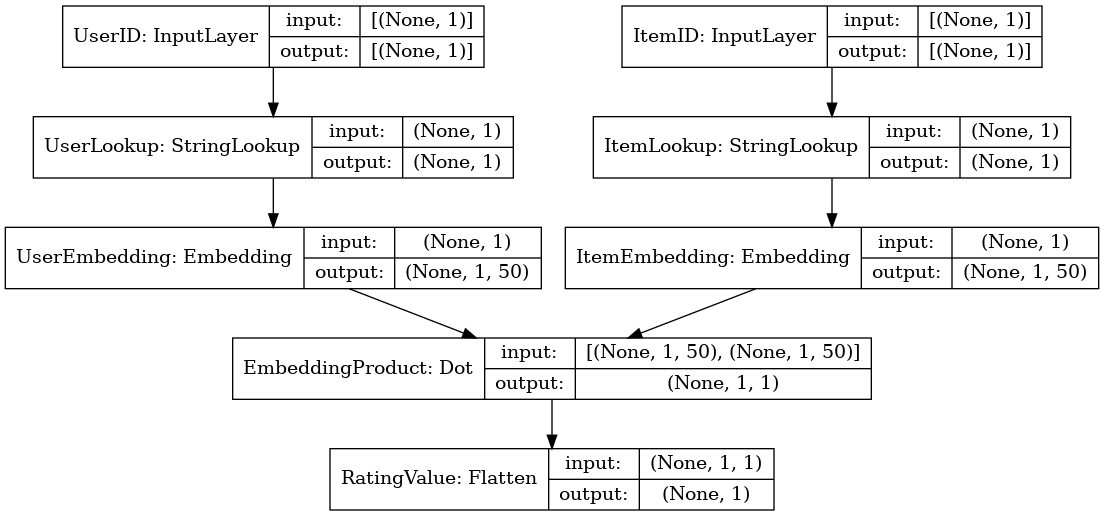

In [19]:
# Clear the global Keras state
tf.keras.backend.clear_session()

# Create model
gd = RecommenderGD(embed_size=50, random_seed=RANDOM_SEED,
                   users=work_ratings_train['user_id'].unique(),
                   items=work_ratings_train['work_id'].unique())

# Show its structure
gd_plot = tf.keras.utils.model_to_dot(
    gd.build_graph(), rankdir='TB',
    show_shapes=True, show_layer_names=True)
Image(gd_plot.create_png())

In [20]:
# Train the model
gd.compile(loss=tf.keras.losses.Huber(),
           optimizer=tf.keras.optimizers.Adam(),
           metrics=[tf.keras.metrics.RootMeanSquaredError(),
                    tf.keras.metrics.MeanAbsoluteError()])
history = gd.fit(x=(work_ratings_train['user_id'],
                    work_ratings_train['work_id']),
                 y=work_ratings_train[['rating']],
                 validation_data=((work_ratings_val['user_id'],
                                   work_ratings_val['work_id']),
                                  work_ratings_val[['rating']]),
                 batch_size=8192, epochs=15, verbose=1)

Epoch 1/15
1280/1280 [==============================] - 211s 164ms/step - loss: 4.5699 - root_mean_squared_error: 5.8881 - mean_absolute_error: 5.0508 - val_loss: 1.8775 - val_root_mean_squared_error: 3.0209 - val_mean_absolute_error: 2.3264
Epoch 2/15
1280/1280 [==============================] - 199s 155ms/step - loss: 1.4570 - root_mean_squared_error: 2.5188 - mean_absolute_error: 1.8931 - val_loss: 1.1951 - val_root_mean_squared_error: 2.1704 - val_mean_absolute_error: 1.6219
Epoch 3/15
1280/1280 [==============================] - 198s 155ms/step - loss: 1.1016 - root_mean_squared_error: 2.0349 - mean_absolute_error: 1.5238 - val_loss: 1.0577 - val_root_mean_squared_error: 1.9659 - val_mean_absolute_error: 1.4783
Epoch 4/15
1280/1280 [==============================] - 198s 155ms/step - loss: 1.0101 - root_mean_squared_error: 1.8946 - mean_absolute_error: 1.4280 - val_loss: 1.0053 - val_root_mean_squared_error: 1.8817 - val_mean_absolute_error: 1.4236
Epoch 5/15
1280/1280 [==========

In [21]:
# Predict rating of user with ID "642850" to work with ID "197888"
gd.predict((np.array(['642850']), np.array(['197888'])))

array([[8.974121]], dtype=float32)

In [22]:
# Show best result
min_val_loss_epoch = np.argmin(history.history['val_loss'])
print(f'RMSE on the train data: '
      f'{history.history["root_mean_squared_error"][min_val_loss_epoch]}')
print(f'RMSE on the validation data: '
      f'{history.history["val_root_mean_squared_error"][min_val_loss_epoch]}')
print(f'MAE on the train data: '
      f'{history.history["mean_absolute_error"][min_val_loss_epoch]}')
print(f'MAE on the validation data: '
      f'{history.history["val_mean_absolute_error"][min_val_loss_epoch]}')

RMSE on the train data: 1.4625763893127441
RMSE on the validation data: 1.730149507522583
MAE on the train data: 1.056846261024475
MAE on the validation data: 1.3102452754974365


The results are better than the SVD-based model. However, this approach also suffers from fast overfitting, so some regularization (for example, L1 or L2) may be useful. In addition, the size of embeddings, there are a lot of other hyperparameters that can be tuned to achieve better quality. The corresponding script for hyperparameter tuning is [here](training_scripts/gradient_descent.py), and the tuning results [on this dashboard](https://app.neptune.ai/evgenytsydenov/book-recommender/experiments?split=tbl&dash=charts&viewId=95a91613-a6e0-474f-8d69-56a4381387c9).

### Gradient Descent with Biases

We move next and now try to implement the idea about users' and items' biases that we started discussing in the SVD section. 

Previous models try to capture the interactions between users and items that produce the rating values. However, ratings can depend not only on interactions but also on factors related to the items and users themselves. These factors (or biases) may be associated with tendencies for some users or items to receive higher or lower ratings than others. For example, if a book is considered good, its average rating is probably higher than the global average of all books. The same can be concluded about users (there may be negative or highly positive users). 

Thus, the actual rating $r_{ui}$ of user $u$ to item $i$ can be decomposed into several components:

$$r_{ui} = r'_{ui} + b_u + b_i + \bar r = \langle \mathbf{p}_{u}, \mathbf{q}_{i} \rangle + b_u + b_i + \bar r$$

where:
- $r'_{ui}$ — rating associated with interaction between user $u$ and item $i$.
- $b_u$ and $b_i$ are user's and item's biases from the global average rating $\bar r$.
- $\mathbf{p}_{u}$ and $\mathbf{q}_{i}$ — user's and item's embeddings like in the previous section.

With known ratings $r_{ui}$ we can estimate all these components using the gradient descent to optimize the following:

$$\min_{b_{*}, q_{*}, p_{*}} = \sum_{u, i} (r_{u, i} - b_u - b_i - \bar r - \langle \mathbf{p}_{u}, \mathbf{q}_{i} \rangle)^2$$

Or if to use L2 regularization:

$$\min_{b_{*}, q_{*}, p_{*}} = \sum_{u, i} (r_{u, i} - b_u - b_i - \bar r - \langle \mathbf{p}_{u}, \mathbf{q}_{i} \rangle) + \lambda \cdot (b^2_u + b^2_i + \|\mathbf{p}_{u}\|_2 + \|\mathbf{q}_{i}\|_2)$$

where $\lambda$ controls the regularization penalty.

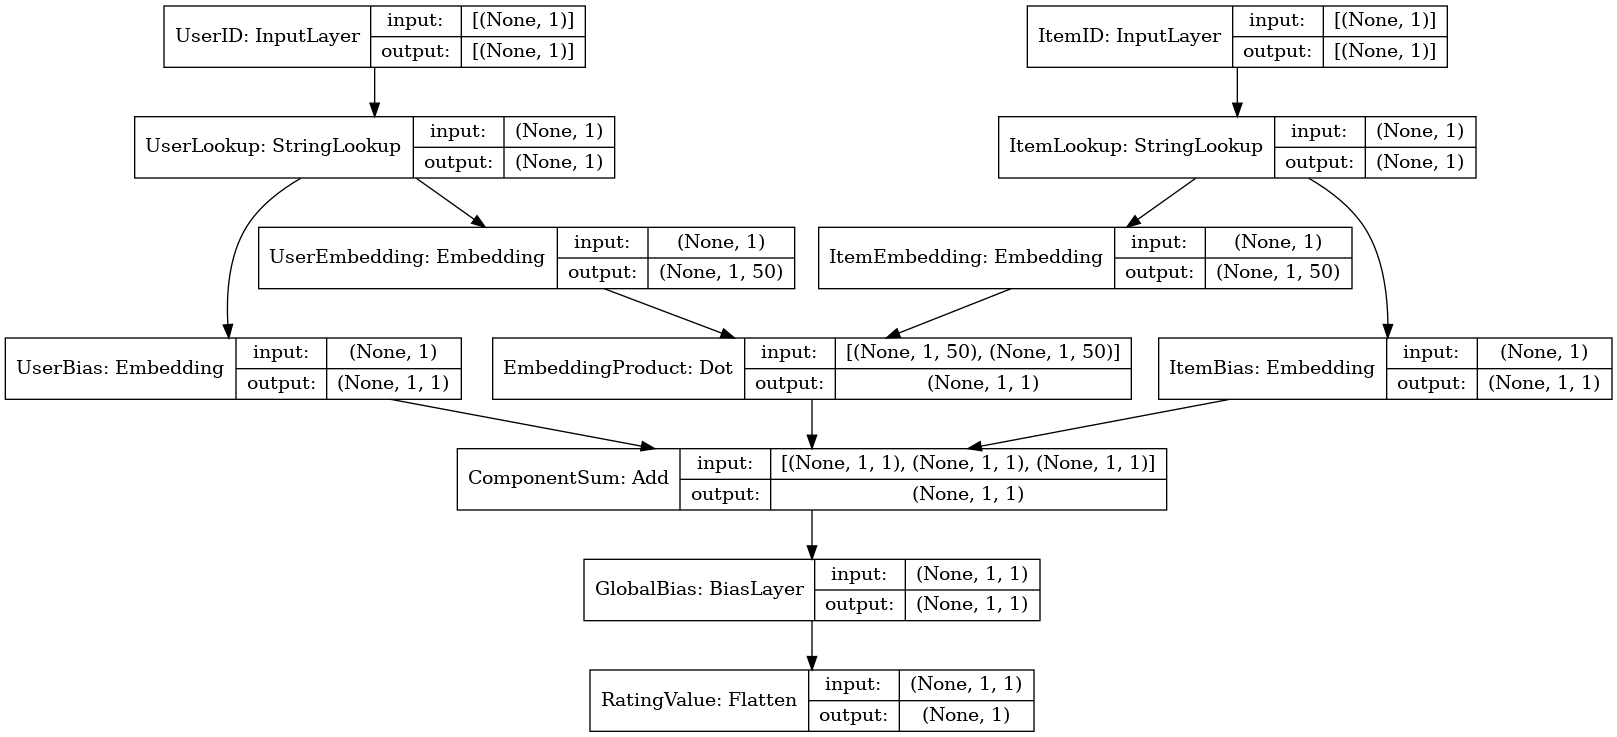

In [23]:
# Clear the global Keras state
tf.keras.backend.clear_session()

# Create model
gd_biased = RecommenderGDBiased(embed_size=50, random_seed=RANDOM_SEED,
                                users=work_ratings_train['user_id'].unique(),
                                items=work_ratings_train['work_id'].unique())

# Show its structure
gd_biased_plot = tf.keras.utils.model_to_dot(
    gd_biased.build_graph(), rankdir='TB',
    show_shapes=True, show_layer_names=True)
Image(gd_biased_plot.create_png())

In [24]:
# Train the model
gd_biased.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(),
                           tf.keras.metrics.MeanAbsoluteError()])
history = gd_biased.fit(x=(work_ratings_train['user_id'],
                           work_ratings_train['work_id']),
                        y=work_ratings_train[['rating']],
                        validation_data=((work_ratings_val['user_id'],
                                          work_ratings_val['work_id']),
                                         work_ratings_val[['rating']]),
                        batch_size=8192, epochs=15, verbose=1)

Epoch 1/15
1280/1280 [==============================] - 211s 164ms/step - loss: 4.0695 - root_mean_squared_error: 5.4118 - mean_absolute_error: 4.5462 - val_loss: 1.5679 - val_root_mean_squared_error: 2.6019 - val_mean_absolute_error: 2.0104
Epoch 2/15
1280/1280 [==============================] - 206s 161ms/step - loss: 1.2574 - root_mean_squared_error: 2.2156 - mean_absolute_error: 1.6883 - val_loss: 1.0818 - val_root_mean_squared_error: 1.9803 - val_mean_absolute_error: 1.5050
Epoch 3/15
1280/1280 [==============================] - 198s 155ms/step - loss: 1.0125 - root_mean_squared_error: 1.8832 - mean_absolute_error: 1.4314 - val_loss: 0.9912 - val_root_mean_squared_error: 1.8501 - val_mean_absolute_error: 1.4093
Epoch 4/15
1280/1280 [==============================] - 206s 161ms/step - loss: 0.9500 - root_mean_squared_error: 1.7947 - mean_absolute_error: 1.3651 - val_loss: 0.9562 - val_root_mean_squared_error: 1.7997 - val_mean_absolute_error: 1.3723
Epoch 5/15
1280/1280 [==========

In [25]:
# Show best result
min_val_loss_epoch = np.argmin(history.history['val_loss'])
print(f'RMSE on the train data: '
      f'{history.history["root_mean_squared_error"][min_val_loss_epoch]}')
print(f'RMSE on the validation data: '
      f'{history.history["val_root_mean_squared_error"][min_val_loss_epoch]}')
print(f'MAE on the train data: '
      f'{history.history["mean_absolute_error"][min_val_loss_epoch]}')
print(f'MAE on the validation data: '
      f'{history.history["val_mean_absolute_error"][min_val_loss_epoch]}')

RMSE on the train data: 1.4700615406036377
RMSE on the validation data: 1.715478777885437
MAE on the train data: 1.0586369037628174
MAE on the validation data: 1.2970526218414307


[The results](https://app.neptune.ai/evgenytsydenov/book-recommender/experiments?split=tbl&dash=charts&viewId=95aa3f80-08ec-4cb3-8b04-ec14f1929aa7) of hyperparameter tuning with [the same script](training_scripts/gradient_descent.py) are better than with the SVD and GD models (without users' and items' biases). Thus, the approach with biases has an effect.

## Content-Based Methods

Systems implementing a content-based recommendation approach analyze descriptions of items previously rated by a user and build a model or profile of user interests based on the features of the items rated by that user. In general, such systems consists of three components that are described below.

At this moment, we will just describe the methods, but the implementation will be done in the future. The text sources are mostly [Kim Falks' book](https://www.goodreads.com/book/show/28510003-practical-recommender-systems) and [Recommender Systems Handbook](https://www.goodreads.com/book/show/6765527-recommender-systems-handbook).

#### Content analyzer

The content analyzer is a component that’s given descriptive data about item content and has the task of mapping that data into something, such as a vector, the machine can use.

Data about books are book authors, year of publication, abstract, genre, etc. So, they can be represented as numbers, categories, text, etc. To convert categorical data into numbers, one-hot encoding, ordinal encoding, or something like that can be used. However, it is more interesting how to handle the text descriptions.

One of the approaches to convert text (e.g., book abstract) into a vector of numbers is to use the [TF-IDF algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This algorithm considers words or "terms" in the text description that occur frequently in one text (TF = term-frequency), but rarely in the other (IDF = inverse-document-frequency), to be more relevant to the topic of the text. So, we can pass text description into the TF-IDF model and get a vector of numbers corresponding to the weights of each word in this text. This approach is quite popular, but there is a better one — [Latent Dirichlet Allocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) (LDA).

The main idea behind LDA is that a text description is a combination of topics, and each topic is a combination of words. The training goal of the LDA model is to find topics so that the text description can be converted into vectors of weights of each topic in this text. Details of LDA and TF-IDF approaches are well explained [in Kim Falks' book](https://www.goodreads.com/book/show/28510003-practical-recommender-systems). In addition, there are other algorithms (e.g. [word2vec](https://jalammar.github.io/illustrated-word2vec/)) that can be used to convert text into vector.

So, to implement a content analyzer, it is necessary to get a deeper understanding of item content: what is it, how to convert it into numbers, how to compose features, and which of them to use.

#### Profile learner

This component collects item representatives of the user preferences and tries to generalize this data, in order to construct the user profile. Usually, the generalization strategy is realized through machine learning techniques, which are able to infer a model of user interests starting from items liked or disliked in the past.

In order to build the profile of the active user $u$, the training set $T_u$ must be defined. $T_u$ is a set of pairs $\langle I_k, r_k \rangle$, where $r_k$ is the rating provided by $u$ on the item representation $I_k$. Given a set of item representations labeled with ratings, this component applies supervised learning algorithms to generate a predictive model (the user profile) which is usually stored for later use by the filtering component.

User tastes usually change in time, therefore up-to-date information must be maintained and provided to the profile learner in order to automatically update the user profile.

#### Filtering component

The filtering component exploits the user profile to suggest relevant items by matching the profile representation against that of items to be recommended. Thus, given a new item representation, this component predicts whether it is likely to be of interest for the active user, by comparing features in the item representation to those in the representation of user preferences. 

If we make online recommendations, the filtering component can implement some strategies to rank potentially interesting items according to the relevance with respect to the user profile. Top-ranked items are included in a list of recommendations $L_u$, that is presented to $u$.

## Conclusion

Here, we tested the collaborative filtering approaches and got a model that provides validation MAE equal to 1.27939 (see [this dashboard](https://app.neptune.ai/evgenytsydenov/book-recommender/experiments?split=tbl&dash=charts&viewId=95a8ad38-184d-4545-8042-0cc3a284a3f0)). One way to improve the result is to decrease the sparsity of the interaction matrix by collecting more explicit ratings and implicit ones (book page view time, clicks, adding to favorites, etc.).

Another way is to try different algorithms. If to compare content-based and collaborative filtering approaches, we can outline the following:
- content-based recommenders exploit solely ratings provided by the active user to build his own profile. Instead, collaborative filtering methods need ratings from other users to find the nearest neighbors of the active user.
- content-based techniques have a natural limit in the number and type of features that are associated with the item they recommend. Thus, domain knowledge is often needed in contrast to collaborative filtering.
- the content-based system recommends only items similar to those already rated by the active user. This causes the serendipity problem that consists in highlighting the tendency to produce recommendations with a limited degree of novelty.
- collaborative filtering suffers from the "cold start problem": it is impossible to recommend anything to new users or to new items, or when users or items have too few interactions to be efficiently handled. Сontent-based recommenders are capable to recommend items not rated by any user and suffer less from this problem.

So, we can test algorithms (and their modifications) to find the one that fits better for the considered task. Since each approach has some strengths and weaknesses, we can build a hybrid recommender that combines several types of recommender algorithms to get a more powerful one. This will help not only to improve the average result but also to mitigate the corner cases, where individual algorithms don’t work well. Hybrid approaches are well described in [Kim Falks' book](https://www.goodreads.com/book/show/28510003-practical-recommender-systems) and are very popular today.